In [28]:
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt
from xarray import DataArray
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Source des informations : https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

PTYPE --> This parameter describes the type of precipitation at the surface, at the specified time. A precipitation type is assigned wherever there is a non-zero value of precipitation. In the ECMWF Integrated Forecasting System (IFS) there are only two predicted precipitation variables: rain and snow. Precipitation type is derived from these two predicted variables in combination with atmospheric conditions, such as temperature. Values of precipitation type defined in the IFS: 0: No precipitation, 1: Rain, 3: Freezing rain (i.e. supercooled raindrops which freeze on contact with the ground and other surfaces), 5: Snow, 6: Wet snow (i.e. snow particles which are starting to melt); 7: Mixture of rain and snow, 8: Ice pellets. These precipitation types are consistent with WMO Code Table 4.201. Other types in this WMO table are not defined in the IFS.

TP --> This parameter is the accumulated liquid and frozen water, comprising rain and snow, that falls to the Earth's surface. It is the sum of large-scale precipitation and convective precipitation. Large-scale precipitation is generated by the cloud scheme in the ECMWF Integrated Forecasting System (IFS). The cloud scheme represents the formation and dissipation of clouds and large-scale precipitation due to changes in atmospheric quantities (such as pressure, temperature and moisture) predicted directly by the IFS at spatial scales of the grid box or larger. Convective precipitation is generated by the convection scheme in the IFS, which represents convection at spatial scales smaller than the grid box. This parameter does not include fog, dew or the precipitation that evaporates in the atmosphere before it lands at the surface of the Earth. This parameter is accumulated over a particular time period which depends on the data extracted. For the reanalysis, the accumulation period is over the 1 hour ending at the validity date and time. For the ensemble members, ensemble mean and ensemble spread, the accumulation period is over the 3 hours ending at the validity date and time. The units of this parameter are depth in metres of water equivalent. It is the depth the water would have if it were spread evenly over the grid box. Care should be taken when comparing model parameters with observations, because observations are often local to a particular point in space and time, rather than representing averages over a model grid box.

In [2]:
data = xr.load_dataset("download.nc",engine='netcdf4')
data = data.sel(time=slice('2021-09-01', '2022-09-01'))
data = data.sel(expver = slice(1))
data = data.squeeze('expver')

In [3]:
data['time'] = [int(np.round((pd.to_datetime(x)- datetime.datetime(2021,9,1)).total_seconds()/3600)) for x in data.time.values]
data['rain'] = data['tp'].where(np.round(data.ptype)==1)*1000
data['t2m_celsius'] = data.t2m - 273.15

La dimension temporelle a ici été convertie en heures écoulées depuis 00:00 le 1er septembre. Cela permet de présenter les cartes ci-dessous sur une gamme de valeurs continues plutot que des dates classiques. On peut d'ailleurs bien observer les gradients latitudinaux pour les dates des premiers et derniers -15 celsius sur les cartes.

De plus, les valeurs de précipitations sont multipliées par 1000 car ces dernières sont à l'origine en m.

In [4]:
data = data.drop(['ptype', 'tp', 't2m'])
FIRST = data['time'].where(data.t2m_celsius <= -15).idxmin(dim='time')
LAST = data['time'].where(data.t2m_celsius <= -15).idxmax(dim='time')
START = FIRST.as_numpy()
END = LAST.as_numpy()
MOYENNE = np.empty(END.shape)

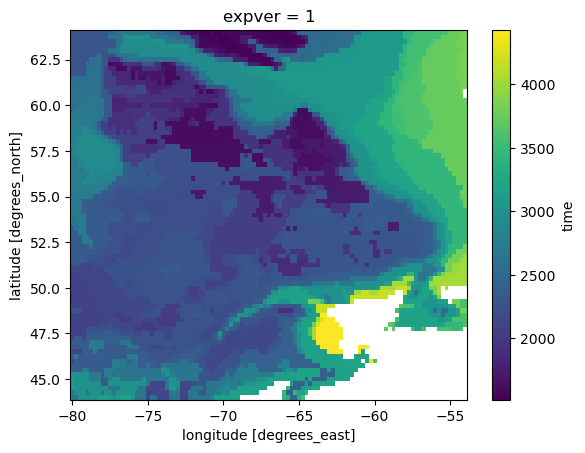

In [5]:
FIRST.plot()

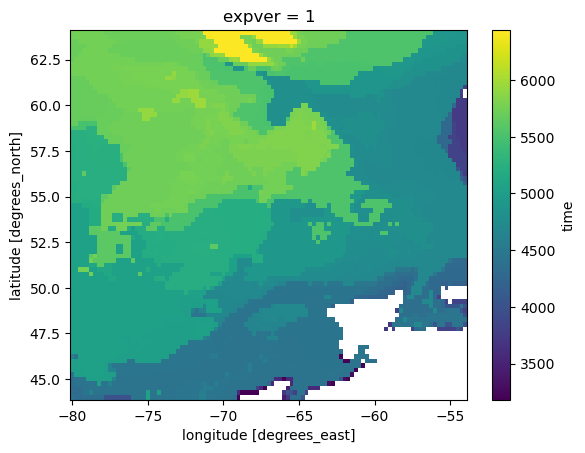

In [6]:
LAST.plot()

In [24]:
for i,x in tqdm(enumerate(data.latitude.values)):
    for j,y in enumerate(data.longitude.values):
        # L'Heure depuis le 1er septembre 2021 qui sert de point de départ à l'analyse.
        START = FIRST[i,j]
        # L'Heure depuis le 1er septembre 2021 qui sert de point d'arrêt à l'analyse.
        END = LAST[i,j]
        # Durée en heures entre la première instance de -15 et la dernière instance de -15.
        LENGTH = END-START
        # Calcul du taux de précipitations journalier moyen en mm/jour aux coordonnées X,Y entre les dates START et END.
        rain_total = np.nansum(data.rain.where((data.longitude==y) & (data.latitude==x) & (data.time >= START) & (data.time <= END)).values)/(LENGTH/24)
        MOYENNE[i,j] = rain_total
data['moyenne'] = (('latitude', 'longitude'), MOYENNE)
data.to_netcdf(path="Average_rain_rate_DAILY_QUEBEC_WINTER_V2.nc")

81it [42:49, 31.73s/it]


Text(0.5, 0.98, 'Précipitations moyennes journalières en mm entre le premier et le dernier -15°C')

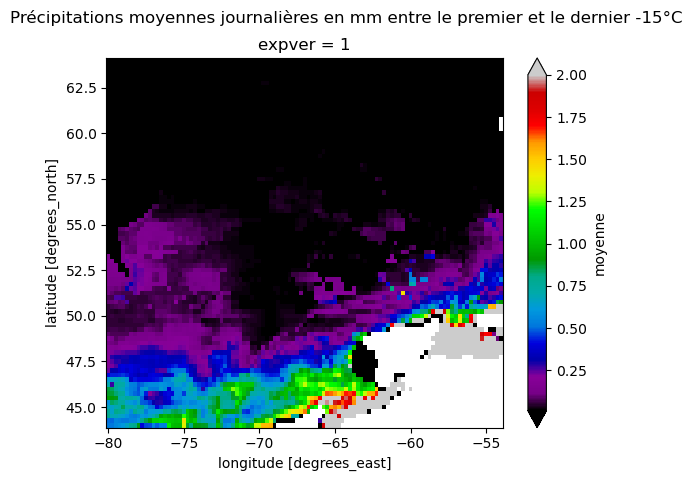

In [50]:
data.moyenne.plot.pcolormesh(cmap='nipy_spectral',vmin=0.01, vmax=2)
plt.suptitle('Précipitations moyennes journalières en mm entre le premier et le dernier -15°C')

In [51]:
xds = xr.open_dataset('Average_rain_rate_DAILY_QUEBEC_WINTER_V2.nc')
xds.moyenne.rio.to_raster('Average_rain_rate_DAILY_QUEBEC_WINTER_V2.tif')